# GPX FROM GARMIN

In [1]:
#%pip install --trusted-host files.pythonhosted.org --trusted-host pypi.org --trusted-host pypi.python.org lxml beautifulsoup4 numpy pandas matplotlib

In [1]:
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

FROM FILE TO DF
---

In [17]:
with open("gpx/ТУДА.gpx", "r", encoding="utf-8") as f:
    text = f.read()
    
soup = BeautifulSoup(text, "xml")
track_points = soup.find_all("trkpt")

In [18]:
lat_lst = []
lon_lst = []
ele_lst = []
time_lst = []

for i, point in enumerate(track_points):
    lat_lst.append(point.attrs["lat"])
    lon_lst.append(point.attrs["lon"])
    ele_lst.append(point.find("ele").text)
    time_lst.append(point.find("time").text)

In [19]:
df = pd.DataFrame({
    "lat": lat_lst,
    "lon": lon_lst,
    "ele": ele_lst,
    "datetime": time_lst
})

PROCESSING
---

In [20]:
df["lon"] = df["lon"].astype(float)
df["lat"] = df["lat"].astype(float)
df["ele"] = df["ele"].astype(float)
df["datetime"] = pd.to_datetime(df["datetime"])
df["lat_shift"] = df["lat"].shift()
df["lon_shift"] = df["lon"].shift()

In [21]:
def dr(row):
    r = 6_371_000
    lat_1 = np.radians(row["lat"])
    lon_1 = np.radians(row["lon"])
    lat_2 = np.radians(row["lat_shift"])
    lon_2 = np.radians(row["lon_shift"]) 
    l = r * np.arccos(
        np.sin(lat_1) * np.sin(lat_2) + np.cos(lat_1) * np.cos(lat_2) * np.cos(lon_1 - lon_2)
    )
    return l

In [22]:
df["dr"] = df.apply(dr, axis=1)
df["dt"] = df["datetime"].diff().dt.total_seconds()
df["speed"] = round( ( df["dr"] / + df["dt"] ) * 3.6 , 2)

In [23]:
df["ele_diff"] = df["ele"].diff()

DATA
---

In [24]:
# Дистанция, записанная трекером
trc_distance = soup.find("gpxtrkx:Distance").text

# Дистанция, рассчитанная (длина дуги на сфере)
distance = round( df["dr"].sum(), 2)

# Кол-во точек в треке
n_points = df["lat"].count()

# Название трека
track_name = soup.find("name").text

# Максимальная скорость
max_speed = df["speed"].max()

# Средняя скорость
avg_speed = round( df["dr"].sum() / df["dt"].sum() * 3.6, 2)

# Самое большое расстояние между точками
longest_part = round( df["dr"].max(), 2)

# Самое маленькое расстояние между точками
smallest_part = round( df["dr"].min(), 2)

# Самое большое время между точками
longest_time = round( df["dt"].max(), 2)

# Самое маленькое время между точками
smallest_time = round( df["dt"].min(), 2)

# Все время в пути
total_time = df["dt"].sum()
hours = total_time // 3600
minutes = ( total_time % 3600 ) // 60
seconds = int(( total_time % 3600 ) % 60)

# Минимальная высота трека
min_ele = df["ele"].min()

# Максимальная высота трека
max_ele = df["ele"].max()

# Спуск
down_distance = -round( df[ df["ele_diff"] < 0 ]["ele_diff"].sum(), 2 )

# Подъем
up_distance = round( df[ df["ele_diff"] > 0 ]["ele_diff"].sum(), 2 )

In [25]:
# Обязательное 
print (f"Наззванеие трека - {track_name}")

print (f"Дистанция измеренная - {trc_distance} м")
print (f"Дистанция рассчитанная - {distance} м")

print (f"Время в пути - {hours} ч {minutes} м {seconds} с")
print (f"Средняя скорость - {avg_speed} км/ч")
print (f"Максимальная скорость - {max_speed} км/ч")

print (f"Максимальная высота маршрута - {max_ele} м")
print (f"Минимальная высота маршрута - {min_ele} м")
print (f"Спуск ⭣ - {down_distance} м")
print (f"Подъем ⭡- {up_distance} м")

print()
# Необязательное
print (f"Количество записанных точек в треке - {n_points}")
print (f"Максимальное расстояние между точками - {longest_part} м")
print (f"Минимальное расстояние между точками - {smallest_part} м")
print (f"Максимальное время между точками - {longest_time} с")
print (f"Минимальное время между точками - {smallest_time} с")

Наззванеие трека - ТУДА
Дистанция измеренная - 2198 м
Дистанция рассчитанная - 2207.81 м
Время в пути - 0.0 ч 10.0 м 18 с
Средняя скорость - 12.86 км/ч
Максимальная скорость - 42.42 км/ч
Максимальная высота маршрута - 131.84 м
Минимальная высота маршрута - 119.82 м
Спуск ⭣ - 20.2 м
Подъем ⭡- 18.28 м

Количество записанных точек в треке - 66
Максимальное расстояние между точками - 149.37 м
Минимальное расстояние между точками - 0.3 м
Максимальное время между точками - 45.0 с
Минимальное время между точками - 1.0 с


In [31]:
with open(f"отчеты/{track_name}.txt", "w", encoding="utf-8") as f:
    f.write(f"Наззванеие трека - {track_name}\n"
            f"\n"
            f"Дистанция измеренная - {trc_distance} м\n"
            f"Дистанция рассчитанная - {distance} м\n"
            f"\n"
            f"Время в пути - {hours} ч {minutes} м {seconds} с\n"
            f"Средняя скорость - {avg_speed} км/ч\n"
            f"Максимальная скорость - {max_speed} км/ч\n"
            f"\n"
            f"Максимальная высота маршрута - {max_ele} м\n"
            f"Минимальная высота маршрута - {min_ele} м\n"
            f"Спуск ⭣ - {down_distance} м\n"
            f"Подъем ⭡- {up_distance} м\n"
    )

In [26]:
df = df[["dr", "ele", "ele_diff", "speed"]]
df = df.fillna(0)
df["cumulative_dr"] = df["dr"].cumsum()
df

,dr,ele,ele_diff,speed,cumulative_dr
0,0.000000,124.63,0.00,0.00,0.000000
1,0.958800,124.15,-0.48,0.20,0.958800
2,5.752797,122.22,-1.93,1.15,6.711597
3,11.675884,122.22,0.00,14.01,18.387480
4,32.674573,122.71,0.49,23.53,51.062053
...,...,...,...,...,...
61,2.304015,119.82,-1.44,0.30,2200.383142
62,2.305970,121.74,1.92,0.42,2202.689112
63,0.300212,122.71,0.97,0.03,2202.989324
64,3.928073,124.15,1.44,0.31,2206.917398


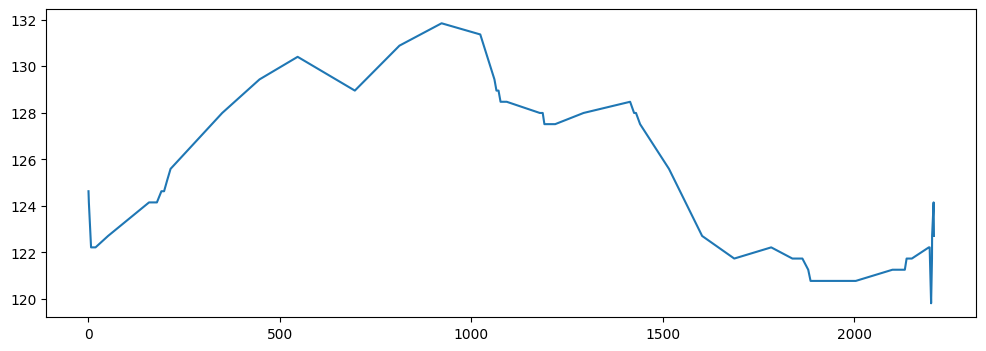

In [27]:
fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(df["cumulative_dr"], df["ele"])
plt.show()

In [81]:
# with open(f"{track_name}.txt", "w", encoding="UTF-8") as f:
#     f.write(f"Поход {track_name}\n"
#             f"Пройденное расстояние - {distance} м\n"
#             f"Средняя скорость - {avg_speed} км/ч\n"
#             f"Максимальная скорость - {max_speed} км/ч\n"
#             f"Время похода - {hours} ч, {minutes} м, {seconds} с\n"
#             f"Самая большая высота - {max_ele} м\n"
#             f"Самая маленькая высота - {min_ele} м\n"
#             f"Спуск - {down_distance} м\n"
#             f"Подъем - {up_distance} м\n"
#             )
